In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Two-dimensional masks

In this notebook we move from 1-dimensional masks to 2-dimensional ones translating the function we defined in the previous notebook.

In [26]:
from sympy.ntheory.primetest import isprime
from scipy.signal import correlate

def ura(r, s, m=1):
    assert(isprime(r))
    assert(isprime(s))
    assert(r - s == 2)
    
    C_r_I = np.zeros(r) - 1
    C_s_J = np.zeros(s) - 1
    for x in range(1, r):
        C_r_I[x**2 % r] = 1
    for y in range(1, s):
        C_s_J[y**2 % s] = 1

    A_IJ = np.zeros([r,s])
    for I in range(r):
        for J in range(s):
            if I == 0:
                A_IJ[I,J] = 0
            elif J == 0:
                A_IJ[I,J] = 1
            elif C_r_I[I] * C_s_J[J] == 1:
                A_IJ[I,J] = 1

    A_ij = np.zeros([m*r,m*s])
    for i in range(m*r):
        for j in range(m*s):
            A_ij[i,j] = A_IJ[i%r,j%s]
    A_ij = np.roll(A_ij, int((r+1)/2), axis=0)
    A_ij = np.roll(A_ij, int((s+1)/2), axis=1)
    
    G_ij = A_ij.copy()
    G_ij[G_ij == 0] = -1
    return A_ij, G_ij

def _pad(A):
    ws = [int(dim/2) for dim in A.shape]
    return np.pad(
        A, 
        pad_width= [(int(dim/2), int(dim/2)) for dim in A.shape], 
        mode = "wrap",
    )

def absorbed(photons, A):
    _A = _pad(A)
    dirx, diry, impx, impy = photons.T
    return _A[dirx + impx, diry + impy] == 0

def transport(photons, A):
    mask_size = A.shape
    transmitted = photons[~absorbed(photons, A)]
    detector, *_ = np.histogram2d(
        x = transmitted[:, 2],
        y = transmitted[:, 3],
        bins=[
            np.arange(mask_size[0] + 1), 
            np.arange(mask_size[1] + 1)
        ]
    )
    return detector

def decode(detector, G):
    n, m = detector.shape
    return correlate(_pad(G), detector)[n-1: -n+1, m-1: -m+1]

## Sanity check


We generate an URA mask.

In [27]:
mask_size = (7,5)
A, G = ura(*mask_size) 

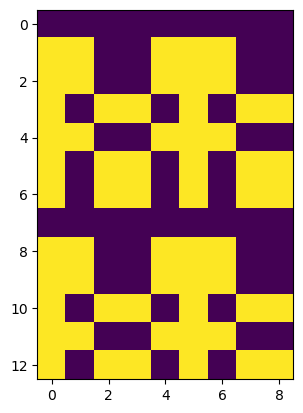

In [28]:
plt.imshow(_pad(A))
plt.show()

To check that code is fine we simulate a simple source, build the detector image and check the decoded image to match the source.

In [32]:
from scipy.stats import poisson, norm

bkg_rate = 1
nbackground = bkg_rate * np.prod(mask_size)

background_photons = np.dstack(
    (np.random.randint(mask_size[0], size=nbackground),
    np.random.randint(mask_size[1], size=nbackground)),
)[0]
background_counts, *_ = np.histogram2d(
    background_photons[:,0], 
    background_photons[:,1], 
    bins=[np.arange(mask_size[0] + 1),np.arange(mask_size[1] + 1)],
)
source = background_counts

In [33]:
def _det(source, A):
    n, m = A.shape
    norm = np.sum(A[A==1])
    detector = correlate(_pad(A), source)[n-1: -n+1, m-1: -m+1] / norm
    return detector

np.allclose(decode(_det(source,A), G), source)

True

Moreover, the mask's PSF is a delta over the detector area.

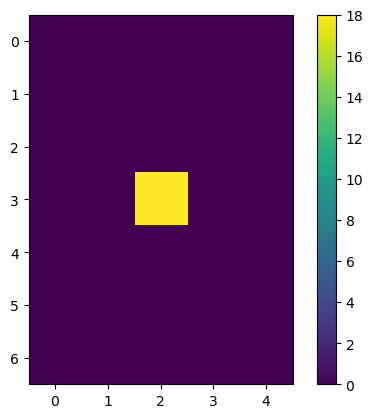

In [34]:
def _corr(A, G):
    n, m = A.shape
    return correlate(_pad(G), A)[n-1: -n+1, m-1: -m+1]

plt.imshow(_corr(A, G))
plt.colorbar()
plt.show()

## Detector simulation

In [8]:
def generate_photons(n: int, A: np.array, direction: np.array):
    mask_size = A.shape
    if type(direction) is str and direction == "random":
        ps = np.dstack(
            (
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
            )
        )[0] 
    else:
        ps = np.dstack(
            (
                *(direction * np.ones((n, 2))).T, 
                np.random.randint(mask_size[0], size=n),
                np.random.randint(mask_size[1], size=n),
            )
        )[0]
    return ps.astype(int)

In [9]:
bkg_rate = 0

nbackground = bkg_rate * np.prod(mask_size)
background_photons = generate_photons(nbackground, A, "random")

In [36]:
nsignals = np.linspace(3, 0, num=1, dtype=int)

signal_dirs = np.dstack([
    np.random.randint(mask_size[0], size=len(nsignals)),
    np.random.randint(mask_size[1], size=len(nsignals)),
])[0]
signal_photons = np.concatenate(
    [
        generate_photons(nsignal, A, signal_dir) 
        for (nsignal, signal_dir) in zip(nsignals, signal_dirs)
    ]
)

In [37]:
photons = np.concatenate((background_photons, signal_photons))
detector = transport(photons, A)

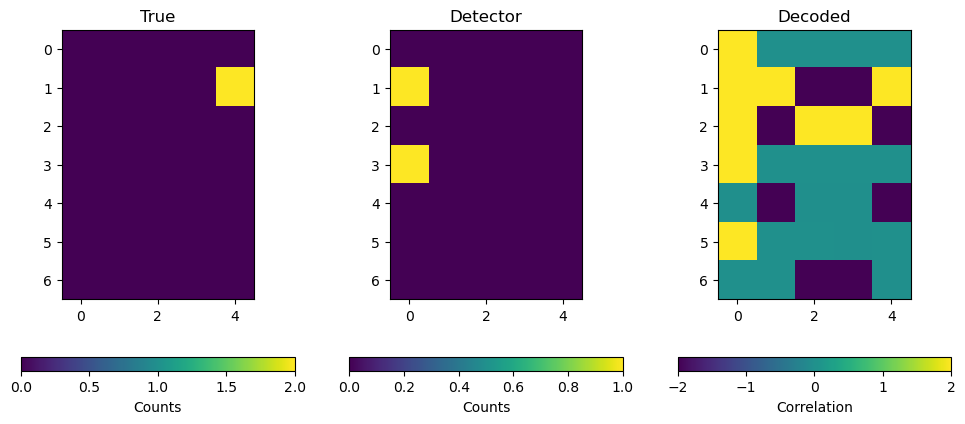

In [38]:
def _src(photons, A):
    transmitted = photons[~absorbed(photons, A)]
    counts, *_ = np.histogram2d(
        x = transmitted[:, 0],
        y = transmitted[:, 1],
        bins=[
            np.arange(mask_size[0] + 1), 
            np.arange(mask_size[1] + 1)
        ]
    )
    return counts

fig, axs = plt.subplots(1, 3, figsize=(12,5) )

c0 = axs[0].imshow(_src(photons, A))
fig.colorbar(c0, ax=axs[0], location="bottom", label="Counts")
axs[0].set_title("True")

c1 = axs[1].imshow(detector)
fig.colorbar(c1, ax=axs[1], location="bottom", label="Counts")
axs[1].set_title("Detector")

decoded = decode(detector, G)
c2 = axs[2].imshow(decoded)
fig.colorbar(c2, ax=axs[2], location="bottom", label="Correlation")
axs[2].set_title("Decoded")

plt.show()